Error: 'Predictions.csv' not found.
First 5 rows:
      Id      SalePrice
0  1461  122343.475839
1  1462  142899.405464
2  1463  202352.108302
3  1464  202645.044724
4  1465  189910.077876
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB

Dataset info:
 None

Summary statistics:
                 Id      SalePrice
count  1459.000000    1459.000000
mean   2190.000000  177804.692228
std     421.321334   54628.469768
min    1461.000000   88339.220127
25%    1825.500000  132751.261385
50%    2190.000000  177449.446963
75%    2554.500000  212153.787395
max    2919.000000  590127.190552

Missing values:
 Id           0
SalePrice    0
dtype: int64


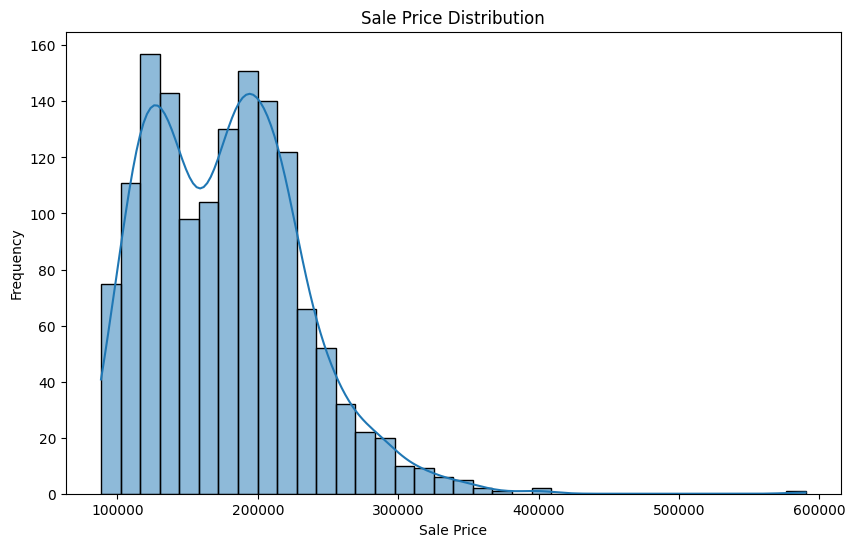

Linear Regression | Mean RMSE: 55058.1892, Std: 3474.5077
Ridge Regression | Mean RMSE: 55058.1622, Std: 3474.5707
Lasso Regression | Mean RMSE: 55058.1882, Std: 3474.5265
Random Forest | Mean RMSE: 50218.9096, Std: 2775.0667
Gradient Boosting | Mean RMSE: 49280.4260, Std: 2849.1767

Best model: Gradient Boosting

Performance on test set:
MSE: 2127006878.23
RMSE: 46119.48
R²: 0.22


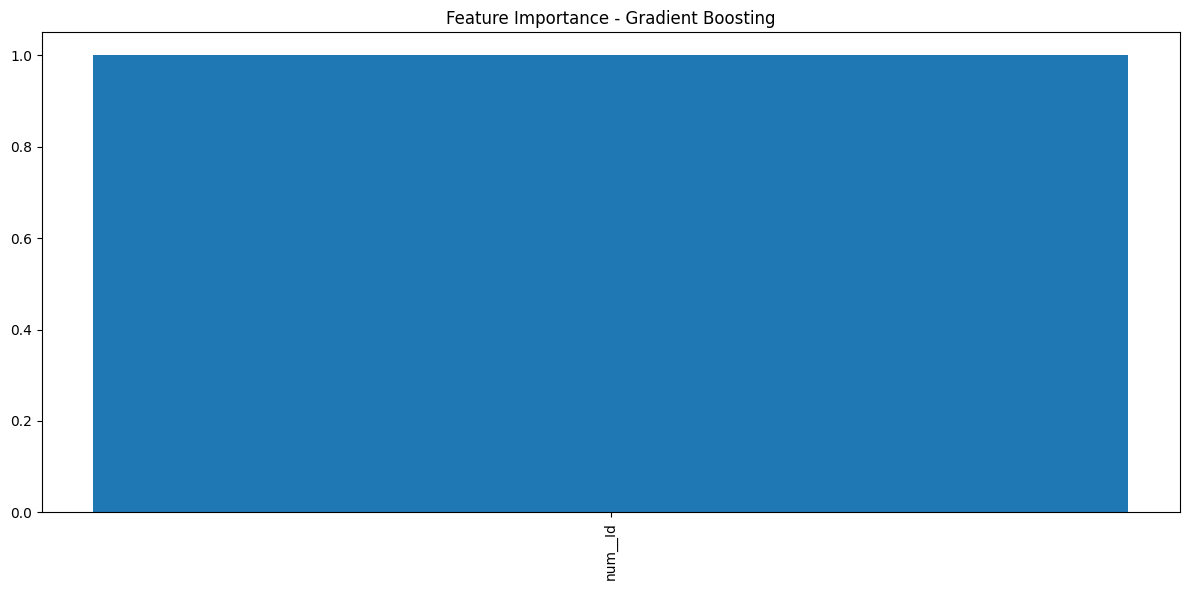

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=4, n_est

In [ ]:
import faulthandler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Optional XGBoost import
try:
    import xgboost as xgb
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")

# 1. Load Data
try:
    df = pd.read_csv(r'C:\Users\welcome\Downloads\Predictions.csv')
except FileNotFoundError:
    print("Error: 'Predictions.csv' not found.")
    exit()

# 2. Data Exploration
print("First 5 rows:\n", df.head())
print("\nDataset info:\n", df.info())
print("\nSummary statistics:\n", df.describe())
print("\nMissing values:\n", df.isnull().sum())

plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True)
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

if 'GrLivArea' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
    plt.title('GrLivArea vs SalePrice')
    plt.xlabel('Above Ground Living Area')
    plt.ylabel('Sale Price')
    plt.show()

if 'Neighborhood' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Neighborhood', y='SalePrice', data=df)
    plt.title('Sale Price by Neighborhood')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 3. Data Preprocessing
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Check for NaNs or Infs
if np.any(np.isnan(X_train_processed)) or np.any(np.isinf(X_train_processed)):
    print("Warning: NaNs or Infs detected in training data!")

X_train_df = pd.DataFrame(
    X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed,
    columns=preprocessor.get_feature_names_out()
)
X_test_df = pd.DataFrame(
    X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed,
    columns=preprocessor.get_feature_names_out()
)

# 4. Model Training
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores)
    results[name] = rmse.mean()
    print(f"{name} | Mean RMSE: {rmse.mean():.4f}, Std: {rmse.std():.4f}")

best_model_name = min(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

best_model.fit(X_train_processed, y_train)
y_pred = best_model.predict(X_test_processed)
print("\nPerformance on test set:")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

# Feature Importance Plot
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X_train_df.columns[indices]
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importance - {best_model_name}")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), features, rotation='vertical')
    plt.tight_layout()
    plt.show()

# 5. Gradient Boosting Hyperparameter Tuning (reduced grid, stable n_jobs)
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}
grid_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    verbose=2
)
grid_gb.fit(X_train_processed, y_train)
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test_processed)
print("\nTuned Gradient Boosting Regressor:")
print(f"Best Params: {grid_gb.best_params_}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gb)):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred_gb):.2f}")

# 6. Optional XGBoost Training
if 'xgb' in globals():
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05],
        'max_depth': [3, 5]
    }
    xgb_model = xgb.XGBRegressor(random_state=42)
    grid_xgb = GridSearchCV(
        xgb_model,
        param_grid_xgb,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=1,
        verbose=2
    )
    grid_xgb.fit(X_train_processed, y_train)
    best_xgb = grid_xgb.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test_processed)
    print("\nTuned XGBoost Regressor:")
    print(f"Best Params: {grid_xgb.best_params_}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
    print(f"Test R²: {r2_score(y_test, y_pred_xgb):.2f}")

# 7. Save Model and Preprocessor
final_model = best_xgb if 'best_xgb' in locals() else best_gb if 'best_gb' in locals() else best_model
joblib.dump(final_model, 'best_house_price_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
print("\nModel and preprocessor saved as 'best_house_price_model.pkl' and 'preprocessor.pkl'.")
